# import library

In [16]:
librosa.__version__

'0.8.1'

In [78]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import librosa, IPython, datetime, time, os, sys, copy, dill, pickle, mir_eval, glob
import numpy as np
import pandas as pd
import IPython.display as ipd
from scipy.spatial.distance import euclidean, pdist, squareform
from time import gmtime, strftime
from imageio import imread as imread
from imageio import imsave as imsave
import librosa.display
import tensorflow as tf
import IPython.display as ipd
import soundfile as sf
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
import pretty_midi
from midiutil.MidiFile import MIDIFile
#from datetime import datetime
#from ops import *
#import pydub
import matplotlib.pyplot as plt
%matplotlib inline

print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))
print ("[info] Python Version:   " + sys.version.split('\n')[0].split(' ')[0])
print ("[info] Working Dir:      " + os.getcwd()+'/')

[info] Current Time:     2021/06/21  14:58:44
[info] Python Version:   3.8.10
[info] Working Dir:      /Users/wazenmaichen/wazenmai/nthu/CS/MIR/Final_Project/drum_generation_with_ssm/


# Define functions

In [79]:
# Ensure File DIR
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define function for MIDI to wav synthesis
def syn_midi(input_midi, output_file, samp_rate):
    print("input_midi: ", input_midi)
    tmp_fname = input_midi.split('/')[-1][:-4] + '_tmp_{}.wav'.format(str(datetime.datetime.now().strftime('%H%M%S')))
    print("tmp_fname: ", tmp_fname)
    # run MIDI to audio synthesis
    syn_cmd = "fluidsynth -ni sound_front_lib.sf2 {} -F {} -r {}".format(input_midi, tmp_fname, samp_rate)
    os.system(syn_cmd)

    #use only 16-bit mono sound, and do volume normalization
    y, sr = librosa.load('{}'.format(tmp_fname), sr=samp_rate, mono=True)
    y = y*0.95/np.max([np.abs(np.max(y)), np.abs(np.min(y))])
    sf.write(output_file, (y * np.iinfo(np.int16).max).astype(np.int16), sr, 'PCM_16')
    try:
        os.system('rm {}'.format(tmp_fname))
    except:
        print ('file is not exist')

    print("MIDI to Audio transfer is done, synthesized file name: {}".format(output_file))
    
print ('Synthesis function define done.')

Synthesis function define done.


# Read all MIDI files

In [80]:
all_tracks_mid_flist = np.sort(glob.glob('./input_midi/**/*.mid', recursive=True)).tolist()
all_tracks_mid_flist = np.sort([x.replace(' ','') for x in all_tracks_mid_flist if "all_tracks.mid" in x]).tolist()
print ('Total files: {}'.format(len(all_tracks_mid_flist)))
# show file format
for x in all_tracks_mid_flist[:]: print (x)

    
no_drum_mid_flist = np.sort(glob.glob('./input_midi/**/*.mid', recursive=True)).tolist()
no_drum_mid_flist = np.sort([x.replace(' ','') for x in no_drum_mid_flist if "no_drum.mid" in x]).tolist()
print ('Total files: {}'.format(len(no_drum_mid_flist)))
# show file format
for x in no_drum_mid_flist[:3]: print (x)
    

drum_only_mid_flist = np.sort(glob.glob('./input_midi/**/*.mid', recursive=True)).tolist()
drum_only_mid_flist = np.sort([x.replace(' ','') for x in drum_only_mid_flist if "drum_only.mid" in x]).tolist()
print ('Total files: {}'.format(len(drum_only_mid_flist)))
# show file format
for x in drum_only_mid_flist[:3]: print (x)

Total files: 24
./input_midi/Beatles_20/02_all_tracks/01_A_Hard_Days_Night_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/02_Anna_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/03_Back_In_The_USSR_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/04_Cant_Buy_Me_Love_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/05_Hold_Me_Tight_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/06_I_Call_Your_Name_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/07_I_Wanna_Be_Your_Man_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/08_Money_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/09_The_Word_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/10_Free_As_A_Bird_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/11_Hey_Jude_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/12_Little_Child_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/13_Hey_Bulldog_all_tracks.mid
./input_midi/Beatles_20/02_all_tracks/14_Lovely_Rita_all_tracks.mid
./input_midi/Bea

# Test SYN MIDI function

In [81]:
file_idx = 20
midi_fname = all_tracks_mid_flist[file_idx]
output_wav_name = './pre_processed_data/syn_wav/' + midi_fname.split('/')[-1][:-4] + '.wav'
ensure_dir(output_wav_name)
syn_midi(midi_fname, output_wav_name, 44100)
print ('[info] MIDI: {}'.format(midi_fname))
print ('[info] WAVE: {}'.format(output_wav_name))

input_midi:  ./input_midi/Michael_Jackson_5/02_all_tracks/22_Michael_Jackson_-_Billie_Jean_all_tracks.mid
tmp_fname:  22_Michael_Jackson_-_Billie_Jean_all_tracks_tmp_145944.wav
MIDI to Audio transfer is done, synthesized file name: ./pre_processed_data/syn_wav/22_Michael_Jackson_-_Billie_Jean_all_tracks.wav
[info] MIDI: ./input_midi/Michael_Jackson_5/02_all_tracks/22_Michael_Jackson_-_Billie_Jean_all_tracks.mid
[info] WAVE: ./pre_processed_data/syn_wav/22_Michael_Jackson_-_Billie_Jean_all_tracks.wav


# define get_merged_mt function

In [82]:
def get_merged_mt(multitrack):
    
    # define track info
    TRACK_INFO = (('Drums', 0),
                  ('Piano', 0),
                  ('Guitar', 24),
                  ('Bass', 32),
                  ('Strings', 48))
    
    """Merge the multitrack pianorolls into five instrument families and
    return the resulting multitrack pianoroll object."""
    track_lists_to_merge = [[] for _ in range(5)]
    for idx, track in enumerate(multitrack.tracks):
        if track.is_drum:
            track_lists_to_merge[0].append(idx)
        elif track.program//8 == 0:
            track_lists_to_merge[1].append(idx)
        elif track.program//8 == 3:
            track_lists_to_merge[2].append(idx)
        elif track.program//8 == 4:
            track_lists_to_merge[3].append(idx)
        elif track.program < 96 or 104 <= track.program < 112:
            track_lists_to_merge[4].append(idx)

    tracks = []
    for idx, track_list_to_merge in enumerate(track_lists_to_merge):
        if track_list_to_merge:
            merged = multitrack[track_list_to_merge].get_merged_pianoroll('max')
            tracks.append(Track(merged, TRACK_INFO[idx][1], (idx == 0),
                                TRACK_INFO[idx][0]))
        else:
            tracks.append(Track(None, TRACK_INFO[idx][1], (idx == 0),
                                TRACK_INFO[idx][0]))
    return Multitrack(None, tracks, multitrack.tempo, multitrack.downbeat, multitrack.beat_resolution, multitrack.name)
#     return Multitrack(None, tracks=tracks, tempo=multitrack.tempo, downbeat=multitrack.downbeat,
#                       resolution=multitrack.resolution, name=multitrack.name)

print ('[info] MIDI merge function defined.')

[info] MIDI merge function defined.


# Define MIDI object to store MIDI data

In [83]:
class midi_track(object):
    def __init__(self):
        self.file_name = ""
        self.pmidi_data = []
        self.pmidi_all_tracks_data = []
        self.pmidi_no_drum_data = []
        self.pmidi_drum_only_data = []
        self.tempo = 0        
        self.downbeats_list_fixed = []
        self.bar_range_list_fixed = []
        self.drum_bar_list = []
        self.drum_bar_list_bin = []
        self.drum_bar_note_num = []
        
print ('MIDI track object is defined.')

MIDI track object is defined.


# loop over all files

In [84]:
midi_obj_list = []

total_files = len(all_tracks_mid_flist)
#total_files = 1

for file_idx in range(0, total_files):

    midi_fname = all_tracks_mid_flist[file_idx]
    print ('[info] file {:2d}:  {}'.format(file_idx+1, midi_fname.split('/')[-1]))
    
    midi_data1_mt = get_merged_mt(Multitrack(midi_fname))
    midi_data1 = midi_data1_mt.to_pretty_midi()
    
    midi_fname = no_drum_mid_flist[file_idx]
    #print (midi_fname)
    midi_data2_mt = get_merged_mt(Multitrack(midi_fname))
    midi_data2 = midi_data2_mt.to_pretty_midi()
    
    midi_fname = drum_only_mid_flist[file_idx]
    #print (midi_fname)
    midi_data3_mt = get_merged_mt(Multitrack(midi_fname))
    midi_data3 = midi_data3_mt.to_pretty_midi()

    # make sure all beat is the same
    all_beat_period = np.sort(midi_data1.get_downbeats()[1:] - midi_data1.get_downbeats()[:-1])
    all_beat_period_avg = np.mean(all_beat_period)
    assert abs((all_beat_period[0] - all_beat_period_avg)/all_beat_period_avg) < 0.05
    assert abs((all_beat_period[-1] - all_beat_period_avg)/all_beat_period_avg) < 0.05
    
    # make sure all tracks are the longest
    assert (midi_data1.get_end_time()>=midi_data2.get_end_time())
    assert (midi_data1.get_end_time()>=midi_data3.get_end_time())
    
    
    # init midi object
    midi_track_obj = midi_track()
    midi_track_obj.file_name = all_tracks_mid_flist[file_idx]
    midi_track_obj.pmidi_data = copy.deepcopy(midi_data1)    
    midi_track_obj.pmidi_all_tracks_data = copy.deepcopy(midi_data1)
    midi_track_obj.pmidi_no_drum_data = copy.deepcopy(midi_data1)
    midi_track_obj.pmidi_drum_only_data = copy.deepcopy(midi_data1)
    
    # get song tempo
    beats_list = midi_track_obj.pmidi_data.get_beats().tolist()
    midi_track_obj.tempo = np.round(60./np.mean(np.array(beats_list[1:]) - np.array(beats_list[:-1])), 2)
    
    # get fixed downbeats data
    downbeats_list = midi_track_obj.pmidi_data.get_downbeats().tolist()
    
    bar_portion = 96
    basic_time_unit = np.mean(np.array(downbeats_list[1:]) - np.array(downbeats_list[:-1]))/bar_portion
    
    # calculate downbeat time range
    downbeats_range_p = np.array(copy.deepcopy(downbeats_list)) + basic_time_unit*0.5
    downbeats_range_n = np.array(copy.deepcopy(downbeats_list)) - basic_time_unit*0.5
    downbeats_range = np.vstack([downbeats_range_n, downbeats_range_p])
    downbeats_range[downbeats_range<0] = 0 
    downbeats_range_cnt = np.zeros(downbeats_range.shape[1])
    downbeats_range_p1_cnt = np.zeros(downbeats_range.shape[1])
    downbeats_range_n1_cnt = np.zeros(downbeats_range.shape[1])

    downbeats_range_num = len(downbeats_list)
    
    for inst_idx in range(0, len(midi_track_obj.pmidi_data.instruments)):
        for note_data in midi_track_obj.pmidi_data.instruments[inst_idx].notes:
            note_onset = note_data.start
            range_found = 0
            # check note in standard downbeats_range
            for beat_range_idx in range(0, downbeats_range_num):
                range_start = downbeats_range[0, beat_range_idx]
                range_end = downbeats_range[1, beat_range_idx]
                if note_onset>=range_start and note_onset<range_end:
                    downbeats_range_cnt[beat_range_idx] += 1
                    range_found = 1
                    break

            if (range_found==1):
                continue
                
            # check note in standard downbeats_range + 1 basic time unit
            for beat_range_idx in range(0, downbeats_range_num):
                range_start = downbeats_range[0, beat_range_idx] + basic_time_unit
                range_end = downbeats_range[1, beat_range_idx] + basic_time_unit
                if note_onset>=range_start and note_onset<range_end:
                    downbeats_range_p1_cnt[beat_range_idx] += 1
                    range_found = 1
                    break         
            
            if (range_found==1):
                continue        
        
            # check note in standard downbeats_range - 1 basic time unit
            for beat_range_idx in range(0, downbeats_range_num):
                range_start = downbeats_range[0, beat_range_idx] - basic_time_unit
                range_end = downbeats_range[1, beat_range_idx] - basic_time_unit
                if note_onset>=range_start and note_onset<range_end:
                    downbeats_range_n1_cnt[beat_range_idx] += 1
                    break 
    
    # calculate downbeat shift
    downbeats_range_shift = np.zeros([downbeats_range_n1_cnt.shape[0]])

    for x in range(downbeats_range_n1_cnt.shape[0]):
        if max([downbeats_range_p1_cnt[x], downbeats_range_n1_cnt[x]]) > downbeats_range_cnt[x]:
            if downbeats_range_p1_cnt[x] > downbeats_range_n1_cnt[x]:
                downbeats_range_shift[x] = 1
            else:
                downbeats_range_shift[x] = -1
                
    # fix downbeats_list
    downbeats_list_fixed = np.array(copy.deepcopy(downbeats_list)) + downbeats_range_shift*basic_time_unit
    downbeats_list_fixed[downbeats_list_fixed<0] = 0
    downbeats_list_fixed = downbeats_list_fixed.tolist()
    

    
    # calculate bar_range_list using downbeats_list_fixed
    bar_range_list_fixed = []
    for beat_idx in range(0, len(downbeats_list_fixed)-1):
        beat_period = downbeats_list_fixed[beat_idx+1] - downbeats_list_fixed[beat_idx]
        
        basic_unit = beat_period/bar_portion
        bar_start = max(downbeats_list_fixed[beat_idx] - basic_unit/2., 0)
        bar_end = min(downbeats_list_fixed[beat_idx+1] - basic_unit/2., downbeats_list_fixed[len(downbeats_list_fixed)-1])
        
        bar_range_list_fixed.append([bar_start, bar_end])
    
    #define function to process note
    def check_note_in_bar(cnib_note_time, cnib_bar_range_list):
        if cnib_note_time>=cnib_bar_range_list[0][0] and cnib_note_time<cnib_bar_range_list[-1][-1]:
            return(True)
        else:
            return(False)

    def get_bar_num(gbn_note_time, gbn_bar_range_list):
        for bar_idx in range(0, len(gbn_bar_range_list)):
            if gbn_note_time>=gbn_bar_range_list[bar_idx][0] and gbn_note_time<gbn_bar_range_list[bar_idx][1]:
                return(bar_idx)
            
    def get_beat_num(gbtn_note_time, gbtn_bar_num, gbtn_downbeats_list):
        time_plus_in_bar = gbtn_note_time - gbtn_downbeats_list[gbtn_bar_num]
        time_plus_in_bar_q = time_plus_in_bar/((gbtn_downbeats_list[gbtn_bar_num+1] - gbtn_downbeats_list[gbtn_bar_num])/bar_portion)
        time_plus_in_bar_q = np.round(time_plus_in_bar_q).astype(int)
        return (time_plus_in_bar_q)
        
    def get_bar_beat(gbb_note_time, gbb_downbeats_list, gbb_bar_range_list):
        note_bar_tmp = get_bar_num(gbb_note_time, gbb_bar_range_list)
        note_beat_tmp = get_beat_num(gbb_note_time, note_bar_tmp, gbb_downbeats_list)
        return(note_bar_tmp, note_beat_tmp)
    
    # put all drum note into bar list
    # create empty list[ ary, ary, ary... ]
    drum_bar_list = []
    for drum_bar_idx in range(0, len(bar_range_list_fixed)):
        bar_note_ary = np.zeros([128, bar_portion])
        drum_bar_list.append(bar_note_ary)
        
    
    # get drum instrument index
    durm_inst_idx_list = []
    for Instrument_idx in range(len(midi_data1.instruments)):
        if midi_data1.instruments[Instrument_idx].is_drum==True:
            durm_inst_idx_list.append(Instrument_idx)       
    assert (len(durm_inst_idx_list)==1)
    durm_inst_idx = durm_inst_idx_list[0]
    
    # put note into drum_bar_list
    for note_data in midi_track_obj.pmidi_data.instruments[durm_inst_idx].notes:
        
        note_onset = note_data.start
        note_pitch = note_data.pitch
        note_velocity = note_data.velocity
        
        if check_note_in_bar(note_onset, bar_range_list_fixed):
            note_bar_0, note_beat_0 = get_bar_beat(note_onset, downbeats_list_fixed, bar_range_list_fixed)        
            
            drum_bar_list[note_bar_0][note_pitch, note_beat_0] = note_velocity

    # save downbeats_list_fixed
    midi_track_obj.downbeats_list_fixed = copy.deepcopy(downbeats_list_fixed)
    
    # save bar_range_list_fixed
    midi_track_obj.bar_range_list_fixed = copy.deepcopy(bar_range_list_fixed)
    
    # save drum bar and notes
    midi_track_obj.drum_bar_list = copy.deepcopy(drum_bar_list)
    midi_track_obj.drum_bar_list_bin = copy.deepcopy(drum_bar_list)
    
    # make note with > 0 value = 1.0
    for bar_idx in range(0, len(midi_track_obj.drum_bar_list_bin)):
        midi_track_obj.drum_bar_list_bin[bar_idx][midi_track_obj.drum_bar_list_bin[bar_idx]>=0.5] = 1.0
        midi_track_obj.drum_bar_list_bin[bar_idx][midi_track_obj.drum_bar_list_bin[bar_idx]<0.5] = 0.0
    
        # save note count
        midi_track_obj.drum_bar_note_num.append(np.round(np.sum(midi_track_obj.drum_bar_list_bin[bar_idx])).astype(int))
    
    
    # save all_tracks_file_name
    midi_fname_nodrum = './pre_processed_data/proc_all_tracks_mid/{}_all_tracks.mid'.format(midi_track_obj.file_name.split('/')[-1][:-15])
    ensure_dir(midi_fname_nodrum)
    midi_track_obj.pmidi_all_tracks_data.write(midi_fname_nodrum)
    #os.system('chown -R sma1033:sma1033 {}'.format(midi_fname_nodrum))
    
    
    # set drum track note velocity=0
    for inst_idx in range(len(midi_track_obj.pmidi_no_drum_data.instruments)):
        if inst_idx==durm_inst_idx:
            for note in midi_track_obj.pmidi_no_drum_data.instruments[inst_idx].notes:        
                note.velocity = 0
                                    
    # save no_drum_midi_file_name
    midi_fname_nodrum = './pre_processed_data/proc_no_drum_mid/{}_no_drum.mid'.format(midi_track_obj.file_name.split('/')[-1][:-15])
    ensure_dir(midi_fname_nodrum)
    midi_track_obj.pmidi_no_drum_data.write(midi_fname_nodrum)
    #os.system('chown -R sma1033:sma1033 {}'.format(midi_fname_nodrum))
    
    wav_fname_nodrum = './pre_processed_data/proc_no_drum_wav/{}_no_drum.wav'.format(midi_track_obj.file_name.split('/')[-1][:-15])
    ensure_dir(wav_fname_nodrum)
    print("wav_fname_nodrum: ", wav_fname_nodrum)
    print("midi_fname_nodrum: ", midi_fname_nodrum)
    syn_midi(midi_fname_nodrum, wav_fname_nodrum, 44100)
    #os.system('chown -R sma1033:sma1033 {}'.format(wav_fname_nodrum))
    
    
    # set Not drum track note velocity=0
    for inst_idx in range(len(midi_track_obj.pmidi_drum_only_data.instruments)):
        if inst_idx!=durm_inst_idx:
            for note in midi_track_obj.pmidi_drum_only_data.instruments[inst_idx].notes:        
                note.velocity = 0
                
    # save no_drum_midi_file_name
    midi_fname_nodrum = './pre_processed_data/proc_drum_only_mid/{}_drum_only.mid'.format(midi_track_obj.file_name.split('/')[-1][:-15])
    ensure_dir(midi_fname_nodrum)
    midi_track_obj.pmidi_drum_only_data.write(midi_fname_nodrum)
    #os.system('chown -R sma1033:sma1033 {}'.format(midi_fname_nodrum))


    # save midi obj into a list
    midi_obj_list.append(midi_track_obj)
    
    
print ('\n[info] All {} files are processed.'.format(total_files))

obj_file_name = './pre_processed_data/proc_midi_object.pkl'
ensure_dir(obj_file_name)
with open(obj_file_name, 'wb') as pkl_file:
    pickle.dump(midi_obj_list, pkl_file)

[info] file  1:  01_A_Hard_Days_Night_all_tracks.mid


/usr/local/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


wav_fname_nodrum:  ./pre_processed_data/proc_no_drum_wav/01_A_Hard_Days_Night_no_drum.wav
midi_fname_nodrum:  ./pre_processed_data/proc_no_drum_mid/01_A_Hard_Days_Night_no_drum.mid
input_midi:  ./pre_processed_data/proc_no_drum_mid/01_A_Hard_Days_Night_no_drum.mid
tmp_fname:  01_A_Hard_Days_Night_no_drum_tmp_150042.wav
MIDI to Audio transfer is done, synthesized file name: ./pre_processed_data/proc_no_drum_wav/01_A_Hard_Days_Night_no_drum.wav
[info] file  2:  02_Anna_all_tracks.mid
wav_fname_nodrum:  ./pre_processed_data/proc_no_drum_wav/02_Anna_no_drum.wav
midi_fname_nodrum:  ./pre_processed_data/proc_no_drum_mid/02_Anna_no_drum.mid
input_midi:  ./pre_processed_data/proc_no_drum_mid/02_Anna_no_drum.mid
tmp_fname:  02_Anna_no_drum_tmp_150049.wav
MIDI to Audio transfer is done, synthesized file name: ./pre_processed_data/proc_no_drum_wav/02_Anna_no_drum.wav
[info] file  3:  03_Back_In_The_USSR_all_tracks.mid
wav_fname_nodrum:  ./pre_processed_data/proc_no_drum_wav/03_Back_In_The_USSR_no

MIDI to Audio transfer is done, synthesized file name: ./pre_processed_data/proc_no_drum_wav/18_Come_Together_no_drum.wav
[info] file 19:  19_Babys_In_Black_all_tracks.mid
wav_fname_nodrum:  ./pre_processed_data/proc_no_drum_wav/19_Babys_In_Black_no_drum.wav
midi_fname_nodrum:  ./pre_processed_data/proc_no_drum_mid/19_Babys_In_Black_no_drum.mid
input_midi:  ./pre_processed_data/proc_no_drum_mid/19_Babys_In_Black_no_drum.mid
tmp_fname:  19_Babys_In_Black_no_drum_tmp_150307.wav
MIDI to Audio transfer is done, synthesized file name: ./pre_processed_data/proc_no_drum_wav/19_Babys_In_Black_no_drum.wav
[info] file 20:  21_Michael_Jackson_-_Bad_all_tracks.mid
wav_fname_nodrum:  ./pre_processed_data/proc_no_drum_wav/21_Michael_Jackson_-_Bad_no_drum.wav
midi_fname_nodrum:  ./pre_processed_data/proc_no_drum_mid/21_Michael_Jackson_-_Bad_no_drum.mid
input_midi:  ./pre_processed_data/proc_no_drum_mid/21_Michael_Jackson_-_Bad_no_drum.mid
tmp_fname:  21_Michael_Jackson_-_Bad_no_drum_tmp_150315.wav
MI

# Extract MIDI file beat/bar information

In [85]:
# reload processed MIDI object
obj_file_name = './pre_processed_data/proc_midi_object.pkl'
with open(obj_file_name, 'rb') as pkl_file:
    midi_obj_list_reload = pickle.load(pkl_file)


# create empty list to store beat/bar info.
song_bar_grid_range_list = []

total_songs = len(midi_obj_list_reload)

for file_idx in range(0, total_songs):

    # load downbeat data
    song_downbeats_list_fixed = midi_obj_list_reload[file_idx].downbeats_list_fixed
    song_bar_range_list_fixed = midi_obj_list_reload[file_idx].bar_range_list_fixed

    bar_resolution = 96

    bar_grid_range_list = []

    beat_num = len(song_downbeats_list_fixed) - 1

    for beat_idx in range(0, beat_num):
        bar_start_edge = song_downbeats_list_fixed[beat_idx]
        bar_end_edge = song_downbeats_list_fixed[beat_idx+1]
        time_grid = np.linspace(bar_start_edge, bar_end_edge, bar_resolution+1)

        bar_grid_range = np.zeros([bar_resolution, 2])

        bar_grid_range[:, 0] = time_grid[ :-1]
        bar_grid_range[:, 1] = time_grid[ 1: ]
        bar_grid_range -= ((time_grid[-1] - time_grid[0])/bar_resolution)*0.5
        bar_grid_range[bar_grid_range<0] = 0

        bar_grid_range_list.append(copy.copy(bar_grid_range))

    print ('Song: {} done, total bars: {}'.format(file_idx, len(bar_grid_range_list)))

    song_bar_grid_range_list.append(copy.copy(bar_grid_range_list))

print ('\nAll {} songs process done.'.format(total_songs))

Song: 0 done, total bars: 101
Song: 1 done, total bars: 81
Song: 2 done, total bars: 91
Song: 3 done, total bars: 94
Song: 4 done, total bars: 86
Song: 5 done, total bars: 84
Song: 6 done, total bars: 101
Song: 7 done, total bars: 91
Song: 8 done, total bars: 88
Song: 9 done, total bars: 79
Song: 10 done, total bars: 140
Song: 11 done, total bars: 68
Song: 12 done, total bars: 74
Song: 13 done, total bars: 62
Song: 14 done, total bars: 109
Song: 15 done, total bars: 67
Song: 16 done, total bars: 111
Song: 17 done, total bars: 95
Song: 18 done, total bars: 52
Song: 19 done, total bars: 118
Song: 20 done, total bars: 140
Song: 21 done, total bars: 133
Song: 22 done, total bars: 100
Song: 23 done, total bars: 146

All 24 songs process done.


# Check Processed beat/bar data

In [86]:
file_idx = 10
bar_idx = 50
bar_grid_range = copy.copy(song_bar_grid_range_list[file_idx][bar_idx])
print(bar_grid_range)

[[ 99.98958333 100.01041667]
 [100.01041667 100.03125   ]
 [100.03125    100.05208333]
 [100.05208333 100.07291667]
 [100.07291667 100.09375   ]
 [100.09375    100.11458333]
 [100.11458333 100.13541667]
 [100.13541667 100.15625   ]
 [100.15625    100.17708333]
 [100.17708333 100.19791667]
 [100.19791667 100.21875   ]
 [100.21875    100.23958333]
 [100.23958333 100.26041667]
 [100.26041667 100.28125   ]
 [100.28125    100.30208333]
 [100.30208333 100.32291667]
 [100.32291667 100.34375   ]
 [100.34375    100.36458333]
 [100.36458333 100.38541667]
 [100.38541667 100.40625   ]
 [100.40625    100.42708333]
 [100.42708333 100.44791667]
 [100.44791667 100.46875   ]
 [100.46875    100.48958333]
 [100.48958333 100.51041667]
 [100.51041667 100.53125   ]
 [100.53125    100.55208333]
 [100.55208333 100.57291667]
 [100.57291667 100.59375   ]
 [100.59375    100.61458333]
 [100.61458333 100.63541667]
 [100.63541667 100.65625   ]
 [100.65625    100.67708333]
 [100.67708333 100.69791667]
 [100.69791667

# save processed bar range information

In [87]:
file_name = './pre_processed_data/proc_midi_beat_bar_info_list.pkl'
with open(file_name, 'wb') as pkl_file:
    pickle.dump(song_bar_grid_range_list, pkl_file)
print ('File is saved.')

File is saved.


# read wav file names

In [88]:
no_drum_wav_flist = np.sort(glob.glob('./pre_processed_data/proc_no_drum_wav/*.wav', recursive=True)).tolist()
print ('Total files: {}'.format(len(no_drum_wav_flist)))
for x in no_drum_wav_flist[:3]: print (x)

Total files: 24
./pre_processed_data/proc_no_drum_wav/01_A_Hard_Days_Night_no_drum.wav
./pre_processed_data/proc_no_drum_wav/02_Anna_no_drum.wav
./pre_processed_data/proc_no_drum_wav/03_Back_In_The_USSR_no_drum.wav


# define function to get CQT data

In [89]:
def get_cqt_data(input_wav_file):

    audio_data, samp_rate = librosa.load(input_wav_file, sr=44100, mono=True)
    audio_len = float(len(audio_data)) / float(samp_rate)
    audio_data_cqt = librosa.amplitude_to_db(np.abs(librosa.cqt(audio_data, sr=samp_rate,  hop_length=256)), ref=np.max)
    audio_cqt_fps = audio_data_cqt.shape[1] / audio_len

    return (audio_data_cqt, audio_cqt_fps)

def get_hybird_cqt_data(input_wav_file):

    audio_data, samp_rate = librosa.load(input_wav_file, sr=44100, mono=True)
    audio_len = float(len(audio_data)) / float(samp_rate) # sec
    audio_data_hybird_cqt = librosa.amplitude_to_db(np.abs(librosa.hybrid_cqt(audio_data, sr=samp_rate, hop_length=256)), ref=np.max)
    audio_hybird_cqt_fps = audio_data_hybird_cqt.shape[1] / audio_len

    return (audio_data_hybird_cqt, audio_hybird_cqt_fps)

def get_vqt_data(input_wav_file):

    audio_data, samp_rate = librosa.load(input_wav_file, sr=44100, mono=True)
    audio_len = float(len(audio_data)) / float(samp_rate) # sec
    audio_data_vqt = librosa.amplitude_to_db(np.abs(librosa.vqt(audio_data, sr=samp_rate, hop_length=256)), ref=np.max)
    audio_vqt_fps = audio_data_vqt.shape[1] / audio_len

    return (audio_data_vqt, audio_vqt_fps)

# loop over files
To get their cqt data

In [103]:
print ('[info] Conversion starts...')
print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S') + '\n')

total_midi_files = len(song_bar_grid_range_list)

bad_file_note_counter = np.zeros(total_midi_files).astype(np.int)

midi_index_start = 0
midi_index_end = total_midi_files

for midi_index in range(midi_index_start, midi_index_end):

    #full_file_name = midi_obj_list_reload[midi_index].file_name

    base_file_name = no_drum_mid_flist[midi_index].split('/')[-1][:-4]

    print('[info] MIDI file: {}'.format(no_drum_mid_flist[midi_index].split('/')[-1]))

#     song_cqt_data, song_cqt_fps = get_cqt_data(no_drum_wav_flist[midi_index])
    song_cqt_data, song_cqt_fps = get_hybird_cqt_data(no_drum_wav_flist[midi_index])
#     song_cqt_data, song_cqt_fps = get_vqt_data(no_drum_wav_flist[midi_index])

    file_bar_num = len(song_bar_grid_range_list[midi_index])

    bars_cqt_list = []

    # loop all bars
    for bar_idx in range(0, file_bar_num):
        single_bar_grid_range = song_bar_grid_range_list[midi_index][bar_idx]

        bar_cqt_notes = []

        # loop all notes in bars
        for note_idx in range(0, 96):
            note_time_start = single_bar_grid_range[note_idx,0]
            note_time_end = single_bar_grid_range[note_idx,1]

            note_frame_start = np.round(note_time_start * song_cqt_fps, 0).astype(np.int)
            note_frame_end = np.round(note_time_end * song_cqt_fps, 0).astype(np.int)

            song_cqt_data_slice = copy.copy(song_cqt_data[:, note_frame_start:note_frame_end])

            # filter out zero case
            if song_cqt_data_slice.shape[1]<1:
                print ('catch a zero slice!')
                print (midi_index, bar_idx, note_idx)
                #song_cqt_data_slice = np.zeros([song_cqt_data.shape[0], 1])
                #song_cqt_data_slice[:] = -80.0                
                cqt_note_84 = cqt_note_84

                bad_file_note_counter[midi_index] += 1

            else:
                cqt_note_84 = np.mean(song_cqt_data_slice, axis=1)

            bar_cqt_notes.append(cqt_note_84)

        bar_cqt_notes_ary = np.array(bar_cqt_notes).transpose()

        bars_cqt_list.append(bar_cqt_notes_ary)

    file_name = './pre_processed_data/cqt_pooled_data/{}.pkl'.format(base_file_name)
    ensure_dir(file_name)
    with open(file_name, 'wb') as pkl_file:
        pickle.dump(bars_cqt_list, pkl_file)

    print ('[info] song: {} done, total bars: {}'.format(base_file_name, len(bars_cqt_list)))

    print('[info] File [ {} / {} ] done.'.format(midi_index-midi_index_start+1, midi_index_end - midi_index_start))

    print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S') + '\n')

print ('\n[info] Conversion ends.')
print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))   

[info] Conversion starts...
[info] Current Time:     2021/06/21  15:23:55

[info] MIDI file: 01_A_Hard_Days_Night_no_drum.mid
[info] song: 01_A_Hard_Days_Night_no_drum done, total bars: 101
[info] File [ 1 / 24 ] done.
[info] Current Time:     2021/06/21  15:24:00

[info] MIDI file: 02_Anna_no_drum.mid
[info] song: 02_Anna_no_drum done, total bars: 81
[info] File [ 2 / 24 ] done.
[info] Current Time:     2021/06/21  15:24:03

[info] MIDI file: 03_Back_In_The_USSR_no_drum.mid
[info] song: 03_Back_In_The_USSR_no_drum done, total bars: 91
[info] File [ 3 / 24 ] done.
[info] Current Time:     2021/06/21  15:24:07

[info] MIDI file: 04_Cant_Buy_Me_Love_no_drum.mid
[info] song: 04_Cant_Buy_Me_Love_no_drum done, total bars: 94
[info] File [ 4 / 24 ] done.
[info] Current Time:     2021/06/21  15:24:11

[info] MIDI file: 05_Hold_Me_Tight_no_drum.mid
[info] song: 05_Hold_Me_Tight_no_drum done, total bars: 86
[info] File [ 5 / 24 ] done.
[info] Current Time:     2021/06/21  15:24:14

[info] MIDI 

# Define function to read CQT data

[info] Total songs: 24
./pre_processed_data/cqt_pooled_data/01_A_Hard_Days_Night_no_drum.pkl
./pre_processed_data/cqt_pooled_data/02_Anna_no_drum.pkl
./pre_processed_data/cqt_pooled_data/03_Back_In_The_USSR_no_drum.pkl

[info] # of bars in song 0: 101
[info] Spectrogram shape: (84, 96)


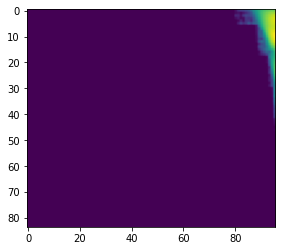

In [104]:
read_pooled_cqt_flist = np.sort(glob.glob('./pre_processed_data/cqt_pooled_data/*.pkl', recursive=True)).tolist()
print ('[info] Total songs: {}'.format(len(read_pooled_cqt_flist)))
for x in read_pooled_cqt_flist[:3]: print (x)

def read_pooled_cqt(file_idx,
                    read_pooled_cqt_flist=read_pooled_cqt_flist):
    
    file_name = read_pooled_cqt_flist[file_idx]
    with open(file_name, 'rb') as pkl_file:
        pooled_cqt_data = pickle.load(pkl_file)
        
    return (pooled_cqt_data)

print ('')
print('[info] # of bars in song 0: {}'.format(len(read_pooled_cqt(0))))
print('[info] Spectrogram shape: {}'.format(read_pooled_cqt(0)[0].shape))

plt.imshow(read_pooled_cqt(1)[2]); plt.show();

# Define CQT SSM calculation function

In [105]:
def get_song_ssm(gss_cqt_spec):
    
    print ('[Info] Start SSM Transfer')
    print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    audio_spec = np.transpose(gss_cqt_spec)
    
    audio_df = pd.DataFrame(audio_spec)

    print('[Info] frame length: {}'.format(len(audio_df.iloc[:,0])))
    print('[Info] pitch class: {}'.format(len(audio_df.iloc[0,:])))

    ssm_data_full_pix = squareform(pdist(audio_df, metric='euclidean'))

    print ('[Info] SSM data shape: {}'.format(ssm_data_full_pix.shape))    
    print ('[Info] SSM transfer done.')
    print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    return (ssm_data_full_pix)


def get_ssm_pix_start_end(gsp_abs_bar, gsp_bar_in_row):
    row = gsp_abs_bar // gsp_bar_in_row
    col = gsp_abs_bar - (gsp_bar_in_row * row)

    row_start = row * 96
    row_end = (row+1) * 96

    col_start = col * 96
    col_end = (col+1) * 96
    
    return([row_start, row_end, col_start, col_end])


def get_ssm_pix_data(gspd_abs_bar, gspd_total_bars_1d, gspd_ssm_data):
        
    xxyy = get_ssm_pix_start_end(gspd_abs_bar, gspd_total_bars_1d)
    
    x_start = xxyy[0]
    x_end = xxyy[1]
    y_start = xxyy[2]
    y_end = xxyy[3]
    
    return(np.mean(gspd_ssm_data[x_start:x_end, y_start:y_end]))


def get_bar_lev_ssm(gbls_ssm):
    
    total_bars_1d = int(np.round(gbls_ssm.shape[1]/96))    
    all_ssm_abs_bar_list = list(range(total_bars_1d**2))
    bar_mean_ssm_data = [get_ssm_pix_data(abs_bar_idx, total_bars_1d, gbls_ssm) for abs_bar_idx in all_ssm_abs_bar_list]
    
    return(np.array(bar_mean_ssm_data).reshape(total_bars_1d, total_bars_1d))


print ('[info] SSM calculation function defined.')

[info] SSM calculation function defined.


# Loop all songs for CQT SSM calculation

In [106]:
print ('[Info] start SSM calculation...')
print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')

song_idx_idx_start = 0
song_idx_idx_end = len(read_pooled_cqt_flist)

for song_idx in range(song_idx_idx_start, song_idx_idx_end):

    base_file_name = no_drum_mid_flist[song_idx].split('/')[-1][:-4]

    print ('[Info] Song Index: {}, {}'.format(song_idx, base_file_name))

    full_song_spec = np.concatenate(read_pooled_cqt(song_idx), axis=1)

    ssm_result = get_song_ssm(full_song_spec)

    bar_ssm_data_tmp = get_bar_lev_ssm(ssm_result)

    file_name = 'song_barlv_ssm_{:0>5}.pkl'.format(base_file_name)
    folder_name = './pre_processed_data/bar_level_cqt_ssm/'
    full_file_name = folder_name + file_name
    ensure_dir(full_file_name)

    with open(full_file_name, 'wb') as pkl_file:
        pickle.dump(bar_ssm_data_tmp, pkl_file)

    print ('[Info] batch SSMs calculation done.')
    print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')

#print(bar_ssm_data_tmp.shape)
print ('\n[info] files write done.')
print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

[Info] start SSM calculation...
[Info] 2021-06-21 15:25:32

[Info] Song Index: 0, 01_A_Hard_Days_Night_no_drum
[Info] Start SSM Transfer
[Info] 2021-06-21 15:25:32
[Info] frame length: 9696
[Info] pitch class: 84
[Info] SSM data shape: (9696, 9696)
[Info] SSM transfer done.
[Info] 2021-06-21 15:25:36
[Info] batch SSMs calculation done.
[Info] 2021-06-21 15:25:36

[Info] Song Index: 1, 02_Anna_no_drum
[Info] Start SSM Transfer
[Info] 2021-06-21 15:25:36
[Info] frame length: 7776
[Info] pitch class: 84
[Info] SSM data shape: (7776, 7776)
[Info] SSM transfer done.
[Info] 2021-06-21 15:25:39
[Info] batch SSMs calculation done.
[Info] 2021-06-21 15:25:39

[Info] Song Index: 2, 03_Back_In_The_USSR_no_drum
[Info] Start SSM Transfer
[Info] 2021-06-21 15:25:39
[Info] frame length: 8736
[Info] pitch class: 84
[Info] SSM data shape: (8736, 8736)
[Info] SSM transfer done.
[Info] 2021-06-21 15:25:42
[Info] batch SSMs calculation done.
[Info] 2021-06-21 15:25:43

[Info] Song Index: 3, 04_Cant_Buy_Me

# Check CQT SSM data

[Info] Song Index: 0, ./pre_processed_data/bar_level_cqt_ssm/song_barlv_ssm_01_A_Hard_Days_Night_no_drum.pkl
[info] SSM shape: (101, 101)


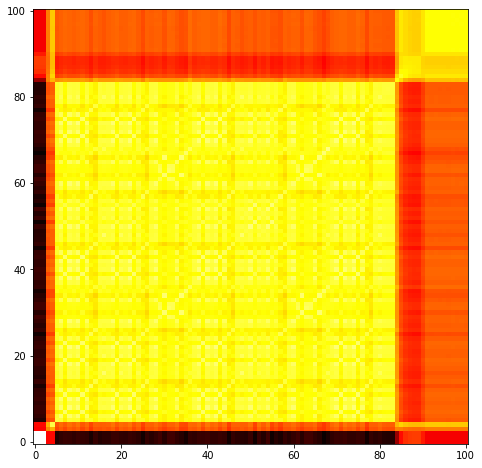

In [107]:
# Hybrid_CQT
def read_cqt_ssm_data(song_idx_in):
    cqt_ssm_flist = np.sort(glob.glob('./pre_processed_data/bar_level_cqt_ssm/*.pkl', recursive=True)).tolist()
    print ('[Info] Song Index: {}, {}'.format(song_idx, cqt_ssm_flist[song_idx_in]))
    with open(cqt_ssm_flist[song_idx_in], 'rb') as pkl_file:
        cqt_ssm_data_reload = pickle.load(pkl_file)
    return (cqt_ssm_data_reload)

# show CQT SSM data
song_idx = 0
plot_data1 = copy.deepcopy(read_cqt_ssm_data(song_idx))
print ('[info] SSM shape: {}'.format(plot_data1.shape))
plt.figure(figsize=(8, 8))
normal_data = plot_data1
abnormal_data = (np.max(normal_data) - normal_data)
plt.imshow(abnormal_data, origin='lower', cmap='hot')
plt.show()

[Info] Song Index: 0, ./pre_processed_data/bar_level_cqt_ssm/song_barlv_ssm_01_A_Hard_Days_Night_no_drum.pkl
[info] SSM shape: (101, 101)


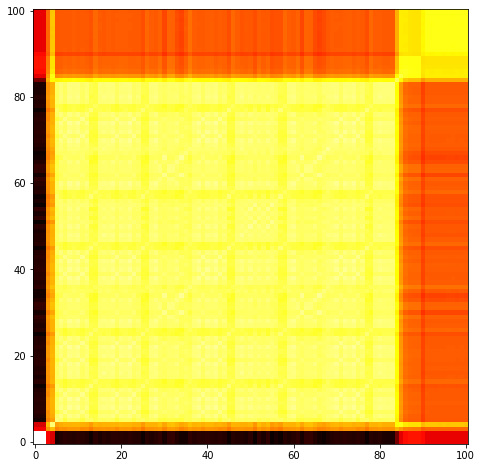

In [97]:
# VQT
def read_cqt_ssm_data(song_idx_in):
    cqt_ssm_flist = np.sort(glob.glob('./pre_processed_data/bar_level_cqt_ssm/*.pkl', recursive=True)).tolist()
    print ('[Info] Song Index: {}, {}'.format(song_idx, cqt_ssm_flist[song_idx_in]))
    with open(cqt_ssm_flist[song_idx_in], 'rb') as pkl_file:
        cqt_ssm_data_reload = pickle.load(pkl_file)
    return (cqt_ssm_data_reload)

# show CQT SSM data
song_idx = 0
plot_data1 = copy.deepcopy(read_cqt_ssm_data(song_idx))
print ('[info] SSM shape: {}'.format(plot_data1.shape))
plt.figure(figsize=(8, 8))
normal_data = plot_data1
abnormal_data = (np.max(normal_data) - normal_data)
plt.imshow(abnormal_data, origin='lower', cmap='hot')
plt.show()

[Info] Song Index: 0, ./pre_processed_data/bar_level_cqt_ssm/song_barlv_ssm_01_A_Hard_Days_Night_no_drum.pkl
[info] SSM shape: (101, 101)


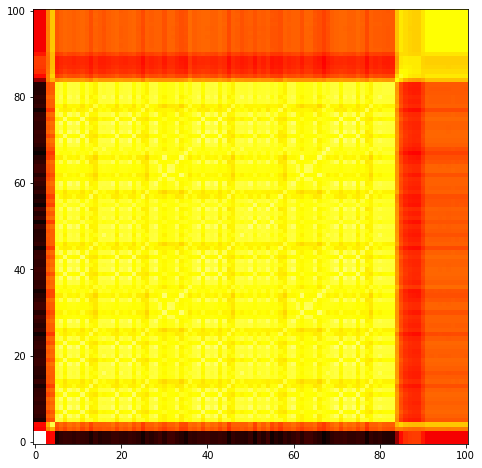

In [102]:
# CQT
def read_cqt_ssm_data(song_idx_in):
    cqt_ssm_flist = np.sort(glob.glob('./pre_processed_data/bar_level_cqt_ssm/*.pkl', recursive=True)).tolist()
    print ('[Info] Song Index: {}, {}'.format(song_idx, cqt_ssm_flist[song_idx_in]))
    with open(cqt_ssm_flist[song_idx_in], 'rb') as pkl_file:
        cqt_ssm_data_reload = pickle.load(pkl_file)
    return (cqt_ssm_data_reload)

# show CQT SSM data
song_idx = 0
plot_data1 = copy.deepcopy(read_cqt_ssm_data(song_idx))
print ('[info] SSM shape: {}'.format(plot_data1.shape))
plt.figure(figsize=(8, 8))
normal_data = plot_data1
abnormal_data = (np.max(normal_data) - normal_data)
plt.imshow(abnormal_data, origin='lower', cmap='hot')
plt.show()

# Condense drum note time step from 96 to 16

## reload midi object

In [60]:
obj_file_name = './pre_processed_data/proc_midi_object.pkl'
with open(obj_file_name, 'rb') as pkl_file:
    midi_track_obj_list = pickle.load(pkl_file)
print ('[info] Total songs: {}'.format(len(midi_track_obj_list)))

[info] Total songs: 24


## plot data format before condese (128 x 96)

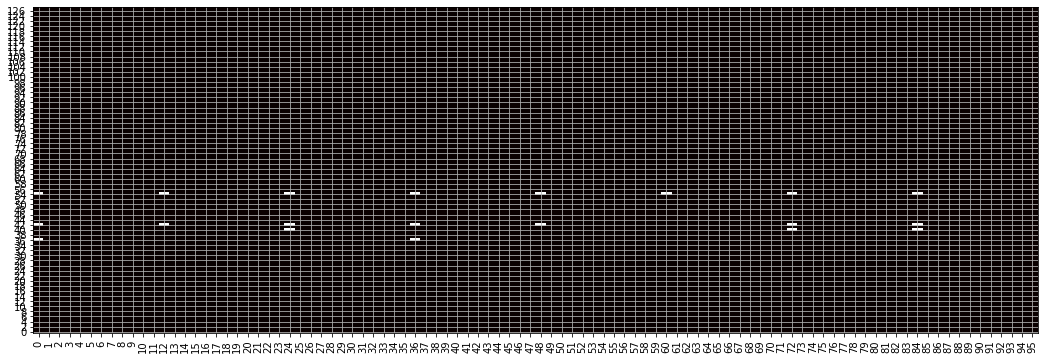

In [61]:
song_idx = 1; bar_idx = 80;

plot_data1 = copy.deepcopy(midi_track_obj_list[song_idx].drum_bar_list_bin[bar_idx])

plt.figure(figsize=(18, 6))
plt.imshow(plot_data1, interpolation='nearest', origin='lower', aspect='auto', cmap='hot')
plt.xticks(np.arange(0, plot_data1.shape[1], 1), rotation=90)
plt.yticks(np.arange(0, plot_data1.shape[0], 2))
#plt.ylim(20,80)
plt.grid() ; plt.show();

## Select instruments to keep in drum channel

In [62]:
# keep 95 % of all instrument count (total 28 insts)
selected_inst_list_28 = [28, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 49, 51, 53, 54, 56, 57, \
                         59, 60, 61, 62, 63, 64, 69, 70, 80, 82]
print ('keeped Insts: {}'.format(len(selected_inst_list_28)))

# keep 99 % of all instrument count (total 46 insts)
selected_inst_list_46 = [27, 28, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, \
                         51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 73, \
                         74, 75, 76, 77, 80, 81, 82, 83, 85, 87]
print ('keeped Insts: {}'.format(len(selected_inst_list_46)))

keeped Insts: 28
keeped Insts: 46


## loop all files to compress drum [pitch / time] data

In [63]:
song_drum_bar_list_28 = []
song_drum_bar_list_46 = []

total_files = len(midi_track_obj_list)

for file_idx in range(total_files):

    single_song_drum_bar_list = copy.deepcopy(midi_track_obj_list[file_idx].drum_bar_list_bin)
    concat_bars_array = np.concatenate(copy.deepcopy(single_song_drum_bar_list), axis=1)
    #print (concat_bars_array.shape)

    drum_bars_list_28 = []
    drum_bars_list_46 = []    

    total_bars_num = len(single_song_drum_bar_list)

    time_step_in_bar = single_song_drum_bar_list[0].shape[1]

    t_range_base = np.array(list(range(0, time_step_in_bar, int(time_step_in_bar/16))))

    for bar_idx in range(0, total_bars_num):

        t_range = t_range_base + bar_idx*time_step_in_bar
        t_range_n1 = copy.deepcopy(t_range_base + bar_idx*time_step_in_bar -1)
        t_range_n1[t_range_n1<0] = 0
        t_range_p1 = copy.deepcopy(t_range_base + bar_idx*time_step_in_bar +1)
        t_range_p1[t_range_n1>concat_bars_array.shape[1]] = concat_bars_array.shape[1]


        select_bar = concat_bars_array[:, t_range]
        select_bar_n1 = concat_bars_array[:, t_range_n1]
        select_bar_p1 = concat_bars_array[:, t_range_p1]

        bar_mixed = select_bar + select_bar_n1 + select_bar_p1
        bar_mixed[bar_mixed>=0.5] = 1
        bar_mixed[bar_mixed<0.5] = 0
        bar_mixed_select_28 = copy.deepcopy(bar_mixed[selected_inst_list_28, :])        
        bar_mixed_select_46 = copy.deepcopy(bar_mixed[selected_inst_list_46, :])

        drum_bars_list_28.append(copy.deepcopy(bar_mixed_select_28))        
        drum_bars_list_46.append(copy.deepcopy(bar_mixed_select_46))


    print ('[info] file idx: [ {} / {} ], total bars: {}'.format(file_idx, 
                                                                 total_files-1, 
                                                                 len(drum_bars_list_28)))

    song_drum_bar_list_28.append(drum_bars_list_28)
    song_drum_bar_list_46.append(drum_bars_list_46)

print ('\n[info] All songs are processed.')

[info] file idx: [ 0 / 23 ], total bars: 101
[info] file idx: [ 1 / 23 ], total bars: 81
[info] file idx: [ 2 / 23 ], total bars: 91
[info] file idx: [ 3 / 23 ], total bars: 94
[info] file idx: [ 4 / 23 ], total bars: 86
[info] file idx: [ 5 / 23 ], total bars: 84
[info] file idx: [ 6 / 23 ], total bars: 101
[info] file idx: [ 7 / 23 ], total bars: 91
[info] file idx: [ 8 / 23 ], total bars: 88
[info] file idx: [ 9 / 23 ], total bars: 79
[info] file idx: [ 10 / 23 ], total bars: 140
[info] file idx: [ 11 / 23 ], total bars: 68
[info] file idx: [ 12 / 23 ], total bars: 74
[info] file idx: [ 13 / 23 ], total bars: 62
[info] file idx: [ 14 / 23 ], total bars: 109
[info] file idx: [ 15 / 23 ], total bars: 67
[info] file idx: [ 16 / 23 ], total bars: 111
[info] file idx: [ 17 / 23 ], total bars: 95
[info] file idx: [ 18 / 23 ], total bars: 52
[info] file idx: [ 19 / 23 ], total bars: 118
[info] file idx: [ 20 / 23 ], total bars: 140
[info] file idx: [ 21 / 23 ], total bars: 133
[info] file 

## save condensed drum midi data

In [64]:
file_name = 'song_drum_bar_list_28.pkl'
folder_name = './pre_processed_data/cdsed_drum_bar_list_28_46/'
full_file_name = folder_name + file_name
ensure_dir(full_file_name)

with open(full_file_name, 'wb') as pkl_file:
    pickle.dump(song_drum_bar_list_28, pkl_file)
    print ('[info] {} is saved.'.format(full_file_name))

file_name = 'song_drum_bar_list_46.pkl'
folder_name = './pre_processed_data/cdsed_drum_bar_list_28_46/'
full_file_name = folder_name + file_name
ensure_dir(full_file_name)

with open(full_file_name, 'wb') as pkl_file:
    pickle.dump(song_drum_bar_list_46, pkl_file)
    print ('[info] {} is saved.'.format(full_file_name))

[info] ./pre_processed_data/cdsed_drum_bar_list_28_46/song_drum_bar_list_28.pkl is saved.
[info] ./pre_processed_data/cdsed_drum_bar_list_28_46/song_drum_bar_list_46.pkl is saved.


## check total note numbers

In [65]:
song_note_num = 0
for file_idx in range(len(midi_track_obj_list)):
    single_song_drum_bar_list = copy.deepcopy(midi_track_obj_list[file_idx].drum_bar_list_bin)
    concat_bars_array = np.concatenate(copy.deepcopy(single_song_drum_bar_list), axis=1)
    song_note_num += np.sum(concat_bars_array).astype(int)
print ('[info] Total full-inst drum note num: {}'.format(song_note_num))

song_note_num = 0
for song_idx in range(0, len(song_drum_bar_list_46)):
    song_note_num += np.sum(np.array(song_drum_bar_list_46[song_idx])).astype(int)
print ('[info] Total 28-inst drum note num: {}'.format(song_note_num))

song_note_num = 0
for song_idx in range(0, len(song_drum_bar_list_28)):
    song_note_num += np.sum(np.array(song_drum_bar_list_28[song_idx])).astype(int)
print ('[info] Total 46-inst drum note num: {}'.format(song_note_num))

[info] Total full-inst drum note num: 39283
[info] Total 28-inst drum note num: 38490
[info] Total 46-inst drum note num: 37864


## Show simplified drum data (28/46 insts)

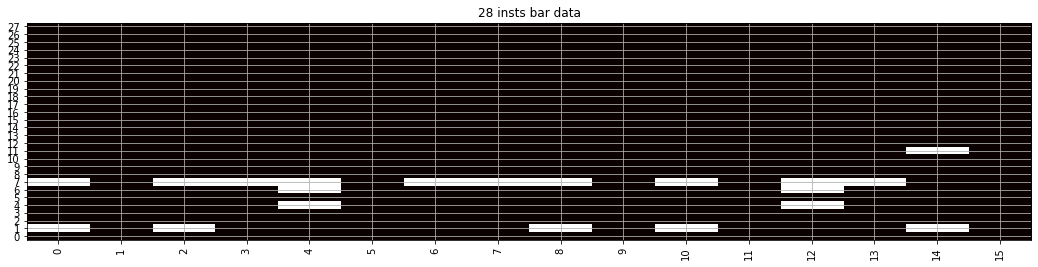

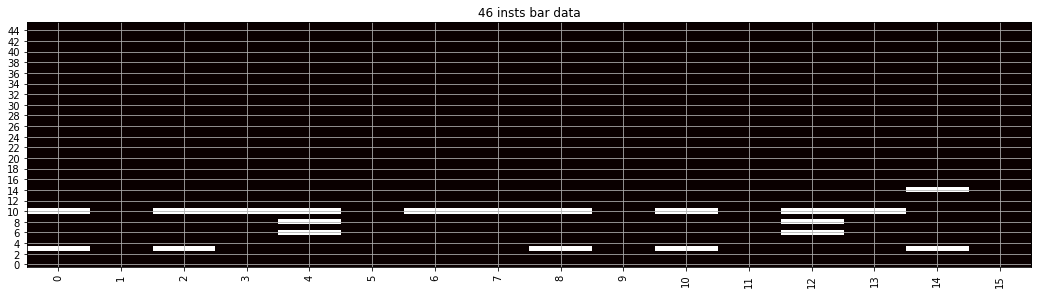

In [66]:
song_idx = 22; bar_idx = 50;

# show 28 instruments data
plot_data1 = copy.deepcopy(song_drum_bar_list_28[song_idx][bar_idx])
plt.figure(figsize=(18, 4))
plt.imshow(plot_data1, interpolation='nearest', origin='lower', aspect='auto', cmap='hot')
plt.xticks(np.arange(0, plot_data1.shape[1], 1), rotation=90)
plt.yticks(np.arange(0, plot_data1.shape[0], 1))
#plt.ylim(20,80)
plt.title('28 insts bar data'); plt.grid() ; plt.show();

# show 46 instruments data
plot_data2 = copy.deepcopy(song_drum_bar_list_46[song_idx][bar_idx])
plt.figure(figsize=(18, 4.5))
plt.imshow(plot_data2, interpolation='nearest', origin='lower', aspect='auto', cmap='hot')
plt.xticks(np.arange(0, plot_data2.shape[1], 1), rotation=90)
plt.yticks(np.arange(0, plot_data2.shape[0], 2))
#plt.ylim(20,80)
plt.title('46 insts bar data'); plt.grid() ; plt.show();

## loop over files to calculate 46-inst drum SSM

In [67]:
total_files = len(midi_track_obj_list)

drum_ssm_data_list = []

for song_idx in range(0, total_files):

    #if song_idx > 10: break

    drum_data = copy.deepcopy(song_drum_bar_list_46[song_idx])

    print ('[info] Song idx: {} , Total bars: {}'.format(song_idx, len(drum_data)))
    #print ('Bars data shape: {}'.format(drum_data[0].shape))

    drum_data_flat = np.array([np.reshape(x, np.prod(x.shape)) for x in drum_data])
    #print (drum_data_flat.shape)

    drum_df = pd.DataFrame(drum_data_flat)

    #print('frame length: {}'.format(len(drum_df.iloc[:,0])))
    #print('pitch class: {}'.format(len(drum_df.iloc[0,:])))

    drum_ssm_data = squareform(pdist(drum_df, metric='euclidean'))

    print ('SSM data shape: {}'.format(drum_ssm_data.shape))
    print ('SSM data mean: {:.2f}'.format(np.mean(drum_ssm_data)))
    print ('SSM data std: {:.2f}'.format(np.std(drum_ssm_data)))
    print ('SSM data max: {:.2f}'.format(np.max(drum_ssm_data)))
    print ('SSM data min: {:.2f}'.format(np.min(drum_ssm_data)))
    print ('')

    drum_ssm_data_list.append(copy.copy(drum_ssm_data))

print ('\n\n[info] Process done, total songs: {}'.format(len(drum_ssm_data_list)))

[info] Song idx: 0 , Total bars: 101
SSM data shape: (101, 101)
SSM data mean: 3.11
SSM data std: 2.13
SSM data max: 5.74
SSM data min: 0.00

[info] Song idx: 1 , Total bars: 81
SSM data shape: (81, 81)
SSM data mean: 3.03
SSM data std: 1.78
SSM data max: 5.83
SSM data min: 0.00

[info] Song idx: 2 , Total bars: 91
SSM data shape: (91, 91)
SSM data mean: 3.14
SSM data std: 1.25
SSM data max: 5.57
SSM data min: 0.00

[info] Song idx: 3 , Total bars: 94
SSM data shape: (94, 94)
SSM data mean: 1.42
SSM data std: 1.48
SSM data max: 3.46
SSM data min: 0.00

[info] Song idx: 4 , Total bars: 86
SSM data shape: (86, 86)
SSM data mean: 2.14
SSM data std: 2.21
SSM data max: 5.20
SSM data min: 0.00

[info] Song idx: 5 , Total bars: 84
SSM data shape: (84, 84)
SSM data mean: 1.65
SSM data std: 1.24
SSM data max: 4.80
SSM data min: 0.00

[info] Song idx: 6 , Total bars: 101
SSM data shape: (101, 101)
SSM data mean: 1.12
SSM data std: 1.55
SSM data max: 4.24
SSM data min: 0.00

[info] Song idx: 7 , 

## Check drum SSM data

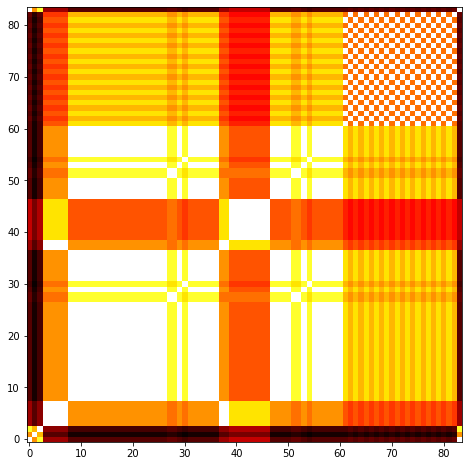

In [68]:
# show data 1
song_idx = 5
plot_data1 = copy.deepcopy(drum_ssm_data_list[song_idx])
plt.figure(figsize=(8, 8))
normal_data = plot_data1
abnormal_data = (np.max(normal_data) - normal_data)
plt.imshow(abnormal_data, origin='lower', cmap='hot')
plt.show()

## Save all drum SSM data

In [69]:
print ('[Info] start SSM saving...')
print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')

song_idx_idx_start = 0
song_idx_idx_end = len(drum_ssm_data_list)

for song_idx in range(song_idx_idx_start, song_idx_idx_end):

    base_file_name = drum_only_mid_flist[song_idx].split('/')[-1][:-4]
    print ('[Info] Song Index: {}, {}'.format(song_idx, base_file_name))

    file_name = 'song_barlv_ssm_{:0>5}.pkl'.format(base_file_name)
    folder_name = './pre_processed_data/bar_level_drum_ssm/'
    full_file_name = folder_name + file_name
    ensure_dir(full_file_name)

    with open(full_file_name, 'wb') as pkl_file:
        pickle.dump(drum_ssm_data_list[song_idx], pkl_file)

    print ('[Info] drum SSMs save done.')
    print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')

#print(bar_ssm_data_tmp.shape)
print ('\n[info] files write done.')
print ('[Info] ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

[Info] start SSM saving...
[Info] 2021-06-20 15:39:00

[Info] Song Index: 0, 01_A_Hard_Days_Night_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 1, 02_Anna_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 2, 03_Back_In_The_USSR_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 3, 04_Cant_Buy_Me_Love_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 4, 05_Hold_Me_Tight_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 5, 06_I_Call_Your_Name_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 6, 07_I_Wanna_Be_Your_Man_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 7, 08_Money_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[Info] Song Index: 8, 09_The_Word_drum_only
[Info] drum SSMs save done.
[Info] 2021-06-20 15:39:00

[In

# define read CQT/drum SSM pkl file function

In [70]:
# load CQT SSM file list
cqt_ssm_flist = np.sort(glob.glob('./pre_processed_data/bar_level_cqt_ssm/*.pkl', recursive=True)).tolist()
print ('Total CQT SSM files: {}'.format(len(cqt_ssm_flist)))

# load drum SSM file list
drum_ssm_flist = np.sort(glob.glob('./pre_processed_data/bar_level_drum_ssm/*.pkl', recursive=True)).tolist()
print ('Total Drum SSM files: {}'.format(len(drum_ssm_flist)))

# define read CQT SSM function
def get_cqt_ssm_data(cqt_file_index, 
                     cqt_ssm_flist_in=cqt_ssm_flist):
    
    cqt_file_name = cqt_ssm_flist_in[cqt_file_index]
    with open(cqt_file_name, 'rb') as pkl_file:        
        load_cqt_data = pickle.load(pkl_file)
    
    # make data value in range [0 ~ 10.5]
    return(load_cqt_data/50.0)

# define read drum SSM function
def get_drum_ssm_data(drum_file_index, 
                      drum_ssm_flist_in=drum_ssm_flist):
    
    drum_file_name = drum_ssm_flist_in[drum_file_index]
    with open(drum_file_name, 'rb') as pkl_file:
        load_drum_data = pickle.load(pkl_file)
    
    # make data value in range [0 ~ 1.0]
    return(load_drum_data/15.0)

print ('function define done.')

Total CQT SSM files: 24
Total Drum SSM files: 24
function define done.


# define CQT padding Function

In [71]:
# output data shape = (256, 256)
def get_cqt_pad(input_ssm_data):
    
    #ssm_with_pad = np.zeros([260, 260])
    ssm_with_pad = np.zeros([256, 256])
    
    input_ssm_h = input_ssm_data.shape[0]
    input_ssm_w = input_ssm_data.shape[1]
    
    if input_ssm_h > 256:
        ssm_data_crop = input_ssm_data[0:256, 0:256]
    else:
        ssm_data_crop = input_ssm_data
    
    #ssm_with_pad[1:input_ssm_h+1, 1:input_ssm_w+1] = copy.copy(input_ssm_data)
    #ssm_with_pad[1:input_ssm_h+1, 1:input_ssm_w+1] = copy.copy(np.rot90(np.triu(np.transpose(input_ssm_data), k=1)))
    #ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.rot90(np.triu(np.transpose(ssm_data_crop), k=1)))
    ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.transpose(ssm_data_crop))
    
    # get value=1 mask as the ssm shape
    #ssm_mask = np.zeros([256, 256])
    #ssm_mask[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.transpose(np.ones_like(ssm_data_crop)))
    
    
    # get original ssm size
    get_original_song_len = input_ssm_data.shape[1]
    
    #return (ssm_with_pad, ssm_mask, get_original_song_len)
    #return (ssm_with_pad, get_original_song_len)
    return (ssm_with_pad)

# show padding SSM shape
file_idx = 0
print('Padding CQT SSM shape: {}'.format(get_cqt_pad(get_cqt_ssm_data(file_idx)).shape))
#print('padding cqt SSM mask shape: {}'.format(get_cqt_pad(cqt_ssm_list[song_index])[1].shape))
#print('padding drum SSM shape: {}'.format(get_padding_ssm(drum_ssm_list[song_index])[0].shape))
#print('padding drum SSM mask shape: {}'.format(get_padding_ssm(drum_ssm_list[song_index])[1].shape))


def get_cqt_pad_refltv(input_ssm_data):
    
    #ssm_with_pad = np.zeros([260, 260])
    ssm_with_pad = np.zeros([256, 256])
    
    input_ssm_h = input_ssm_data.shape[0]
    input_ssm_w = input_ssm_data.shape[1]
    
    repeat_ratio = (256//input_ssm_h) + 2
    
    ssm_htemp = copy.copy(input_ssm_data)
    
    #print ('ratio: {}'.format(repeat_ratio))
    
    for repead_idx in range(0, repeat_ratio):
        ssm_htemp = np.hstack([ssm_htemp, copy.copy(input_ssm_data)])
        #print ('stack: {}'.format(repead_idx))
        
    ssm_vtemp = copy.copy(ssm_htemp)
        
    for repead_idx in range(0, repeat_ratio):
        ssm_vtemp = np.vstack([ssm_vtemp, copy.copy(ssm_htemp)])
    
    
    ssm_full_pad_out = ssm_vtemp[0:256, 0:256]
    
    #if input_ssm_h > 256:
    #    ssm_data_crop = input_ssm_data[0:256, 0:256]
    #else:
    #    ssm_data_crop = input_ssm_data
    
    #ssm_with_pad[1:input_ssm_h+1, 1:input_ssm_w+1] = copy.copy(input_ssm_data)
    #ssm_with_pad[1:input_ssm_h+1, 1:input_ssm_w+1] = copy.copy(np.rot90(np.triu(np.transpose(input_ssm_data), k=1)))
    #ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.rot90(np.triu(np.transpose(ssm_data_crop), k=1)))
    #ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.transpose(ssm_data_crop))
    
    # get value=1 mask as the ssm shape
    #ssm_mask = np.zeros([256, 256])
    #ssm_mask[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.transpose(np.ones_like(ssm_data_crop)))
    
    
    # get original ssm size
    get_original_song_len = input_ssm_data.shape[1]

    #return (ssm_with_pad, ssm_mask, get_original_song_len)    
    #return (ssm_full_pad_out, get_original_song_len)
    return (ssm_full_pad_out)


# show padding SSM shape
file_idx = 0
print('Padding CQT SSM (reflective) shape: {}'.format(get_cqt_pad_refltv(get_cqt_ssm_data(file_idx)).shape))
#print('padding cqt SSM mask shape: {}'.format(get_cqt_pad(cqt_ssm_list[song_index])[1].shape))
#print('padding drum SSM shape: {}'.format(get_padding_ssm(drum_ssm_list[song_index])[0].shape))
#print('padding drum SSM mask shape: {}'.format(get_padding_ssm(drum_ssm_list[song_index])[1].shape))



def get_ssm_vdiff(input_ssm_vdata):
    gsh_ssm_vout_tmp = np.vstack([np.zeros([1, input_ssm_vdata.shape[1]]), input_ssm_vdata])[:input_ssm_vdata.shape[0],:]    
    gsh_ssm_vout = copy.copy(input_ssm_vdata - gsh_ssm_vout_tmp)
    return(gsh_ssm_vout)


def get_ssm_hdiff(input_ssm_hdata):
    gsh_ssm_hout_tmp = np.hstack([np.zeros([input_ssm_hdata.shape[0], 1]), input_ssm_hdata])[:, :input_ssm_hdata.shape[1]]
    gsh_ssm_hout = copy.copy(input_ssm_hdata - gsh_ssm_hout_tmp)
    return(gsh_ssm_hout)

Padding CQT SSM shape: (256, 256)
Padding CQT SSM (reflective) shape: (256, 256)


# Check CQT SSM data

song_length: 81


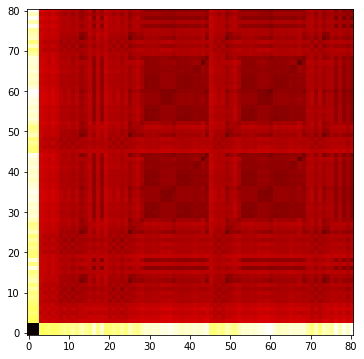

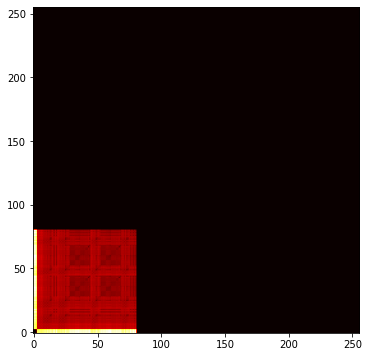

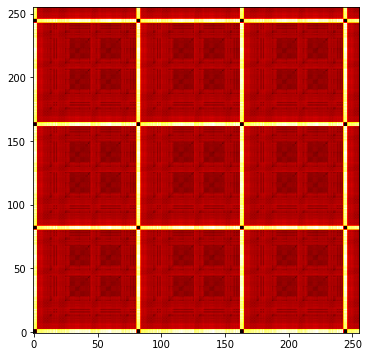

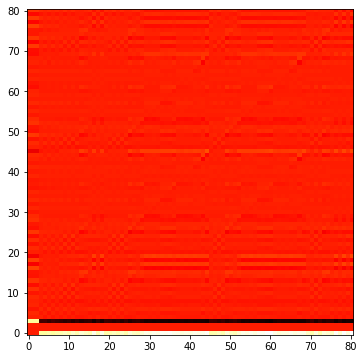

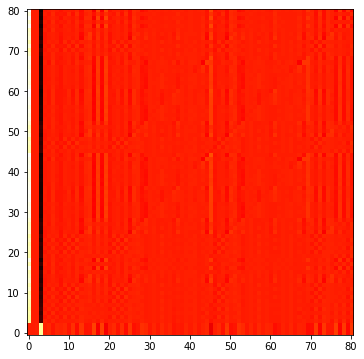

In [72]:
# show cqt ssm data
file_idx = 1

song_length = get_cqt_ssm_data(file_idx).shape[0]
print ('song_length: {}'.format(song_length))

plot_data_0 = get_cqt_ssm_data(file_idx)
plot_data_1 = get_cqt_pad(get_cqt_ssm_data(file_idx))
plot_data_2 = get_cqt_pad_refltv(get_cqt_ssm_data(file_idx))
plot_data_3 = get_ssm_vdiff(get_cqt_ssm_data(file_idx))
plot_data_4 = get_ssm_hdiff(get_cqt_ssm_data(file_idx))


# plot data0 (original SSM)
plt.figure(figsize=(6, 6))
plt.imshow(plot_data_0, origin='lower', cmap='hot')
plt.show()

# plot data1 (pad 256 SSM)
plt.figure(figsize=(6, 6))
plt.imshow(plot_data_1, origin='lower', cmap='hot')
plt.show()

# plot data2 (reflactive padding)
plt.figure(figsize=(6, 6))
plt.imshow(plot_data_2, origin='lower', cmap='hot')
plt.show()

# plot data3 (h axis diff)
plt.figure(figsize=(6, 6))
plt.imshow(plot_data_3, origin='lower', cmap='hot')
plt.show()

# plot data4 (v axis diff)
plt.figure(figsize=(6, 6))
plt.imshow(plot_data_4, origin='lower', cmap='hot')
plt.show()

# define drum SSM padding Function

In [73]:
# output data shape = (256, 256)
def get_drum_pad(input_ssm_data):
    
    canvas_size = 256
    
    ssm_with_pad = np.zeros([canvas_size, canvas_size])
    
    input_ssm_h = input_ssm_data.shape[0]
    input_ssm_w = input_ssm_data.shape[1]
    
    if input_ssm_h > canvas_size:
        ssm_data_crop = input_ssm_data[0:canvas_size, 0:canvas_size]
    else:
        ssm_data_crop = input_ssm_data
    
    #ssm_with_pad[1:input_ssm_h+1, 1:input_ssm_w+1] = copy.copy(input_ssm_data)
    #ssm_with_pad[1:input_ssm_h+1, 1:input_ssm_w+1] = copy.copy(np.rot90(np.triu(np.transpose(input_ssm_data), k=1)))
    #ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.rot90(np.triu(np.transpose(ssm_data_crop), k=1)))
    #ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.transpose(ssm_data_crop))
    #ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.triu(np.transpose(ssm_data_crop)))
    ssm_with_pad[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.transpose(ssm_data_crop))
    
    # get value=1 mask as the ssm shape
    ssm_mask = np.zeros([canvas_size, canvas_size])
    ssm_mask[0:input_ssm_h, 0:input_ssm_w] = copy.copy(np.triu(np.transpose(np.ones_like(ssm_data_crop))))
    
    
    # get original ssm size
    get_original_song_len = input_ssm_data.shape[1]
    
    #return (ssm_with_pad, ssm_mask, get_original_song_len)
    return (ssm_with_pad, ssm_mask)



def get_ssm_vdiff(input_ssm_vdata):
    
    gsh_ssm_vout_tmp = np.vstack([np.zeros([1, input_ssm_vdata.shape[1]]), input_ssm_vdata])[:input_ssm_vdata.shape[0],:]
    
    gsh_ssm_vout = copy.copy(input_ssm_vdata - gsh_ssm_vout_tmp)
    
    #return(gsh_ssm_vout_tmp)
    return(gsh_ssm_vout)


def get_ssm_hdiff(input_ssm_hdata):
    
    gsh_ssm_hout_tmp = np.hstack([np.zeros([input_ssm_hdata.shape[0], 1]), input_ssm_hdata])[:, :input_ssm_hdata.shape[1]]
    
    gsh_ssm_hout = copy.copy(input_ssm_hdata - gsh_ssm_hout_tmp)
    
    #return(gsh_ssm_hout_tmp)
    return(gsh_ssm_hout)


# show data shape
song_idx = 20
#print (get_drum_pad(get_drum_ssm_data(file_idx))[2])
print ('Padding drum SSM shape: {}'.format(get_drum_pad(get_drum_ssm_data(file_idx))[0].shape))
print ('Padding drum SSM mask shape: {}'.format(get_drum_pad(get_drum_ssm_data(file_idx))[1].shape))

Padding drum SSM shape: (256, 256)
Padding drum SSM mask shape: (256, 256)


# Check drum SSM padding data

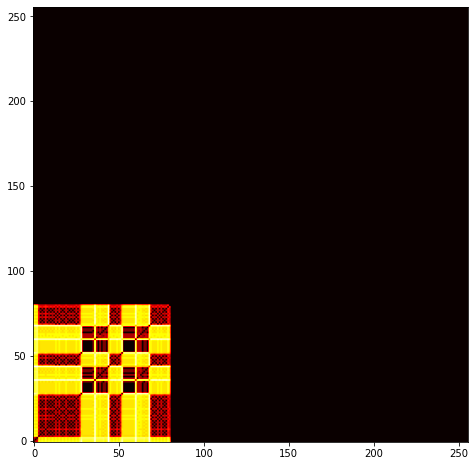

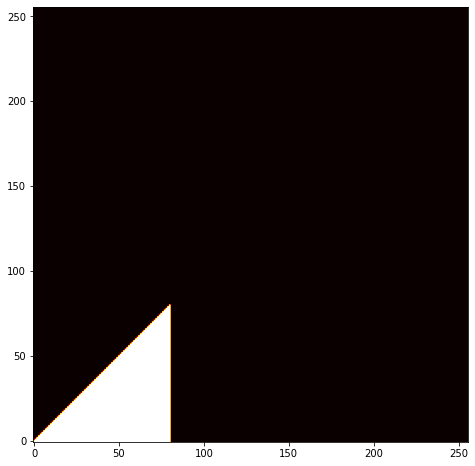

In [74]:
song_idx = 5
plot_data0 = get_drum_pad(get_drum_ssm_data(file_idx))[0]
plot_data1 = get_drum_pad(get_drum_ssm_data(file_idx))[1]

plt.figure(figsize=(8, 8))
plt.imshow(plot_data0, origin='lower', cmap='hot')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(plot_data1, origin='lower', cmap='hot')
plt.show()

# loop over files to add pad 

In [75]:
total_good_files = len(cqt_ssm_flist)

cqt_drum_ssm_data_list = []

for file_idx in range(0, total_good_files):

    song_len = get_cqt_ssm_data(file_idx).shape[0]

    # get cqt SSM data
    cqt_ssm_data_loaded = get_cqt_ssm_data(file_idx)

    cqt_ssm_reflect_pad_no_diff = get_cqt_pad_refltv(cqt_ssm_data_loaded)

    cqt_ssm_reflect_pad_hdiff = get_ssm_hdiff(cqt_ssm_reflect_pad_no_diff)

    cqt_ssm_reflect_pad_vdiff = get_ssm_vdiff(cqt_ssm_reflect_pad_no_diff)

    cqt_ssm_reflect_pad = np.concatenate((cqt_ssm_reflect_pad_no_diff[:,:,np.newaxis],
                                          cqt_ssm_reflect_pad_hdiff[:,:,np.newaxis],
                                          cqt_ssm_reflect_pad_vdiff[:,:,np.newaxis]), 
                                         axis=-1)      



    # get drum SSM data
    drum_ssm_data_loaded = get_drum_ssm_data(file_idx)

    drum_ssm_pad_no_diff = get_drum_pad(drum_ssm_data_loaded)[0]

    drum_ssm_pad_hdiff = get_ssm_hdiff(drum_ssm_pad_no_diff)

    drum_ssm_pad_vdiff = get_ssm_vdiff(drum_ssm_pad_no_diff)

    drum_ssm_pad = np.concatenate((drum_ssm_pad_no_diff[:,:,np.newaxis],
                                   drum_ssm_pad_hdiff[:,:,np.newaxis],
                                   drum_ssm_pad_vdiff[:,:,np.newaxis]), 
                                  axis=-1)     

    drum_ssm_pad_mask = get_drum_pad(drum_ssm_data_loaded)[1]

    drum_ssm_pad_mask_all_layer = np.concatenate((drum_ssm_pad_mask[:,:,np.newaxis],
                                                  drum_ssm_pad_mask[:,:,np.newaxis],
                                                  drum_ssm_pad_mask[:,:,np.newaxis]), 
                                                 axis=-1)    

    ssm_valid_pix = np.mean(drum_ssm_pad_mask)


    # save data into list
    cqt_drum_ssm_data_list.append([cqt_ssm_reflect_pad,
                                   drum_ssm_pad,
                                   drum_ssm_pad_mask_all_layer,
                                   ssm_valid_pix,
                                   song_len])

    if (file_idx+1)%1==0:
        print ('File processed: {}'.format(file_idx+1))


print ('\nAll files are processed: {}'.format(len(cqt_drum_ssm_data_list)))

File processed: 1
File processed: 2
File processed: 3
File processed: 4
File processed: 5
File processed: 6
File processed: 7
File processed: 8
File processed: 9
File processed: 10
File processed: 11
File processed: 12
File processed: 13
File processed: 14
File processed: 15
File processed: 16
File processed: 17
File processed: 18
File processed: 19
File processed: 20
File processed: 21
File processed: 22
File processed: 23
File processed: 24

All files are processed: 24


# check data format

In [76]:
print('[info] Total songs: {}'.format(len(cqt_drum_ssm_data_list)))
print(cqt_drum_ssm_data_list[1][0].shape)
print(cqt_drum_ssm_data_list[1][1].shape)
print(cqt_drum_ssm_data_list[1][2].shape)
print(cqt_drum_ssm_data_list[1][3])
print(cqt_drum_ssm_data_list[1][4])

[info] Total songs: 24
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
0.0506744384765625
81


# save all SSM data

In [77]:
total_files = len(cqt_drum_ssm_data_list)

for file_idx in range(0, total_files):

    cqt_ssm_data_ary = cqt_drum_ssm_data_list[file_idx][0]
    drum_ssm_data_ary = cqt_drum_ssm_data_list[file_idx][1]
    drum_ssm_mask_ary = cqt_drum_ssm_data_list[file_idx][2]
    valid_pix_mean_ary = cqt_drum_ssm_data_list[file_idx][3]
    song_len_data_ary = cqt_drum_ssm_data_list[file_idx][4]

    dump_data = [copy.deepcopy(cqt_ssm_data_ary),
                 copy.deepcopy(drum_ssm_data_ary),
                 copy.deepcopy(drum_ssm_mask_ary),
                 copy.deepcopy(valid_pix_mean_ary),
                 copy.deepcopy(song_len_data_ary)
                 ]

    file_name = 'test_midi_song_{:0>2}.pkl'.format(file_idx)
    folder_name = './pre_processed_data/merged_ssm_pkg/'
    full_file_name = folder_name + file_name    
    ensure_dir(full_file_name)

    with open(full_file_name, 'wb') as pkl_file:
        pickle.dump(dump_data, pkl_file)
        print ('[info] File: \"{}\" is saved.'.format(full_file_name))

print ('\n[info] All SSM pkl files are saved.')

[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_00.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_01.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_02.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_03.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_04.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_05.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_06.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_07.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_08.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_09.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_10.pkl" is saved.
[info] File: "./pre_processed_data/merged_ssm_pkg/test_midi_song_11.pkl" is saved.
[inf